# Let's practice extracting information

## First things first

#### Load the library (and a couple of others)

In [1]:
import pdfplumber
import pandas as pd
import re

#### Open the PDF

In [2]:
pdf = pdfplumber.open("../pdfs/01-practice.pdf")

#### How many pages in the PDF?

In [3]:
len(pdf.pages)

1

#### Select that first/only page

In [4]:
page = pdf.pages[0]
page

<Page:1>

## Text

#### Read the text

In [5]:
print(page.extract_text())

Jungle Health and Safety Inspection Service
INS-UP70N51NCL41R
Site: Durham’s Meatpacking  Chicago, Ill.
Date:  February 3, 1905
Violation Count: 7
Summary: 
Worst of any, however, were the fertilizer men, and those who served in the cooking rooms. These
people could not be shown to the visitor - for the odor of a fertilizer man would scare any ordinary 
visitor at a hundred yards, and as for the other men, who worked in tank rooms full of steam, and in 
some of which there were open vats near the level of the floor, their peculiar trouble was that they fell
into the vats; and when they were fished out, there was never enough of them left to be worth 
exhibiting - sometimes they would be overlooked for days, till all but the bones of them had gone out
to the world as Durham’s Pure Leaf Lard!
Violations
Statute Description Level Repeat?
4.12.7 Unsanitary Working Conditions. Critical
5.8.3 Inadequate Protective Equipment. Serious
6.3.9 Ineffective Injury Prevention. Serious
7.1.5 Failure 

In [6]:
print(page.extract_text(layout=True))




                                                     Jungle Health and Safety Inspection Service
                                                     INS-UP70N51NCL41R

       Site: Durham’s Meatpacking Chicago, Ill.

       Date: February 3, 1905

       Violation Count: 7
       Summary:

       Worst of any, however, were the fertilizer men, and those who served in the cooking rooms. These
       people could not be shown to the visitor - for the odor of a fertilizer man would scare any ordinary
       visitor at a hundred yards, and as for the other men, who worked in tank rooms full of steam, and in
       some of which there were open vats near the level of the floor, their peculiar trouble was that they fell

       into the vats; and when they were fished out, there was never enough of them left to be worth
       exhibiting - sometimes they would be overlooked for days, till all but the bones of them had gone out
       to the world as Durham’s Pure Leaf Lard!








     

## Table extraction

#### All tables (in this example, there's only one)

In [7]:
page.extract_tables()

[[['Statute', 'Description', 'Level', 'Repeat?'],
  ['4.12.7', 'Unsanitary Working Conditions.', 'Critical', ''],
  ['5.8.3', 'Inadequate Protective Equipment.', 'Serious', ''],
  ['6.3.9', 'Ineffective Injury Prevention.', 'Serious', ''],
  ['7.1.5', 'Failure to Properly Store Hazardous Materials.', 'Critical', ''],
  ['8.9.2', 'Lack of Adequate Fire Safety Measures.', 'Serious', ''],
  ['9.6.4', 'Inadequate Ventilation Systems.', 'Serious', ''],
  ['10.2.7',
   'Insufficient Employee Training for Safe Work Practices.',
   'Serious',
   '']]]

#### Just the largest table

In [8]:
pd.DataFrame(page.extract_table())

,0,1,2,3
0,Statute,Description,Level,Repeat?
1,4.12.7,Unsanitary Working Conditions.,Critical,
2,5.8.3,Inadequate Protective Equipment.,Serious,
3,6.3.9,Ineffective Injury Prevention.,Serious,
4,7.1.5,Failure to Properly Store Hazardous Materials.,Critical,
5,8.9.2,Lack of Adequate Fire Safety Measures.,Serious,
6,9.6.4,Inadequate Ventilation Systems.,Serious,
7,10.2.7,Insufficient Employee Training for Safe Work P...,Serious,


## Let's start visual debugging

First, we'll examine the structural parts of the page: Where are the character, rectangle, and line objects? Then we'll show off `.debug_tablefinder(...)`. Then we'll start planning out our extraction.

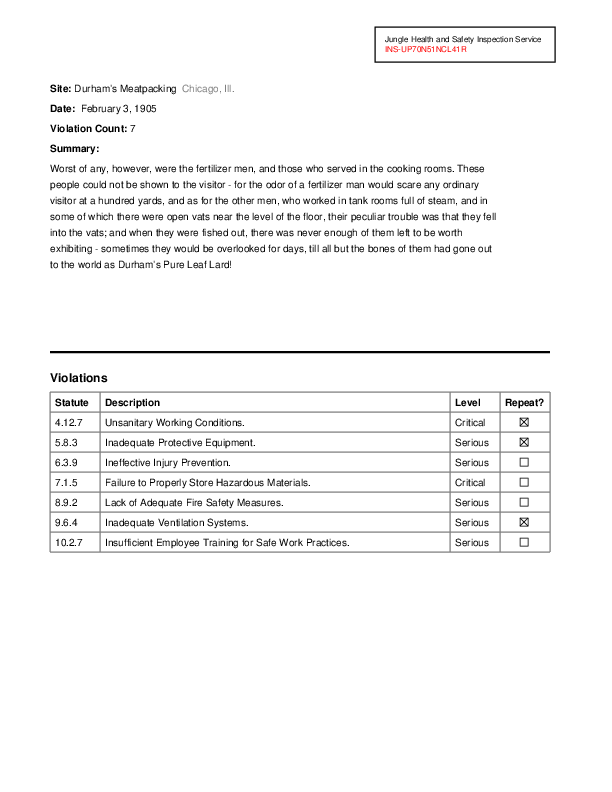

In [9]:
im = page.to_image()
im

#### Characters

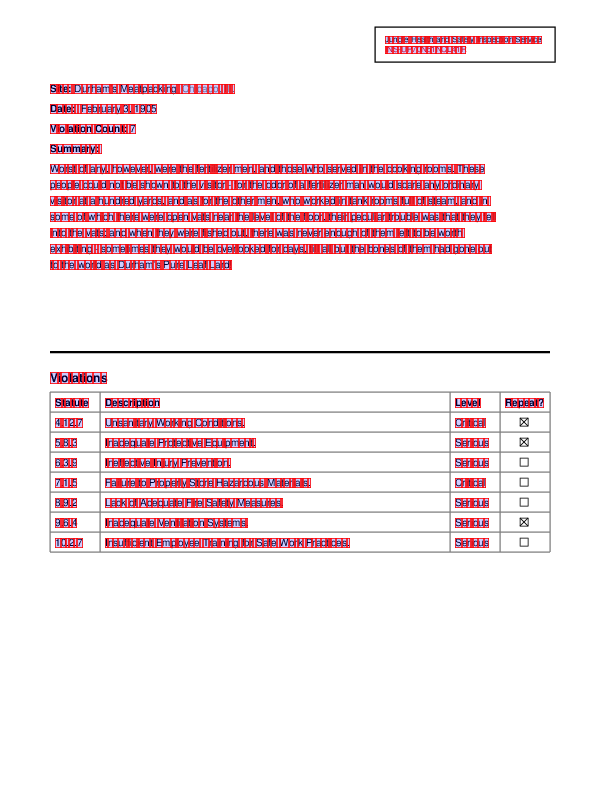

In [10]:
im.reset().draw_rects(page.chars)

#### Rects

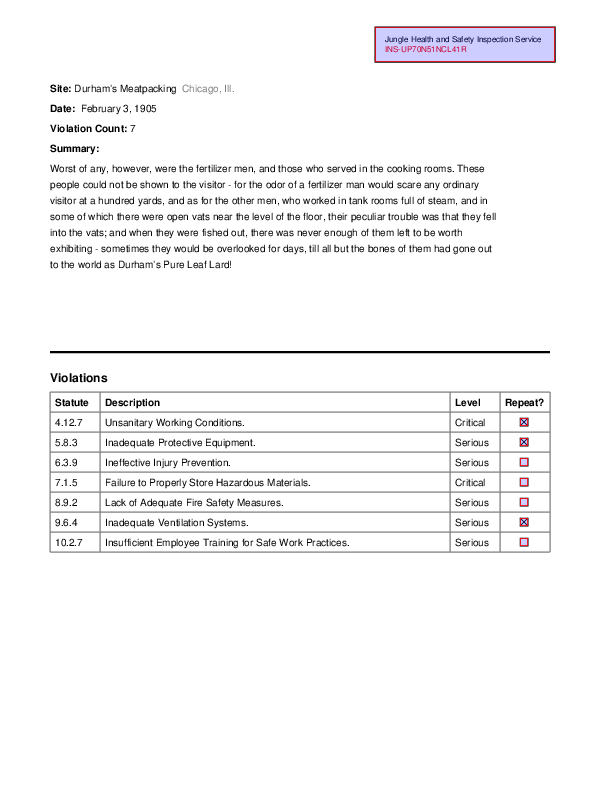

In [11]:
im.reset().draw_rects(page.rects)

#### Lines

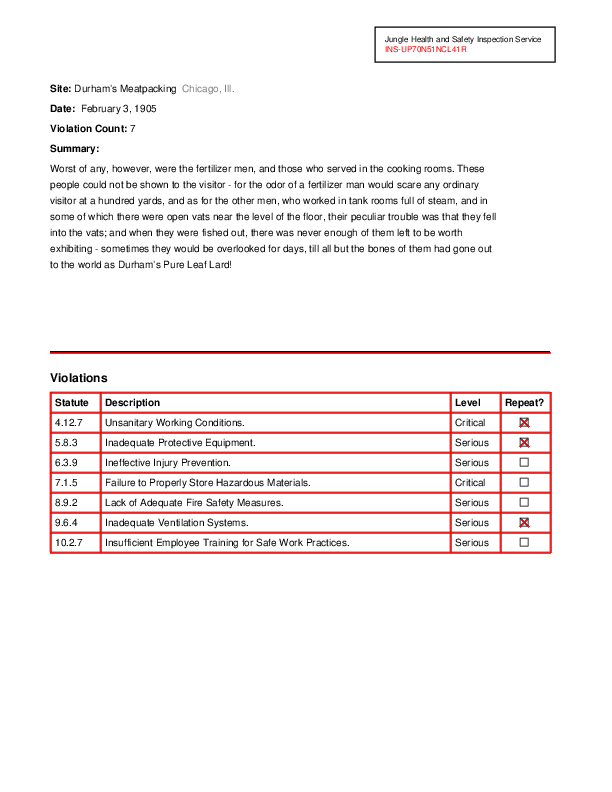

In [12]:
im.reset().draw_lines(page.lines, stroke_width=2)

#### Something we haven't seen before: `debug_tablefinder(...)`

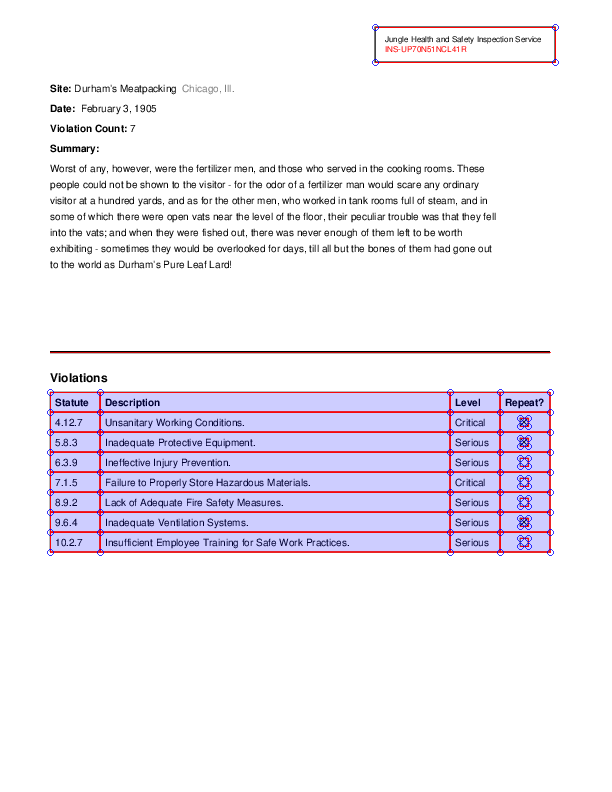

In [13]:
im.reset().debug_tablefinder()

## Planning our extraction

What parts of the page do we want to grab? What are some strategies we might be able to use?

#### Inspection ID

Let's start with the inspection ID, in the box at the top of the page. How might we get that? With PDFs, there's often more than one option. Let's explore them.

One option is just to extract the text and parse it out of there. We might feel confident, perhaps, that the text will always look something like this:

```
Jungle Health and Safety Inspection Service
{Inspection ID}
[...]
```

If that's a safe assumption, then straightforward text extraction should work fine. You could do a simple split or, for more flexibility, how about a regular expression?

In [14]:
text_simple = page.extract_text()
text_simple[:200]

'Jungle Health and Safety Inspection Service\nINS-UP70N51NCL41R\nSite: Durham’s Meatpacking  Chicago, Ill.\nDate:  February 3, 1905\nViolation Count: 7\nSummary: \nWorst of any, however, were the fertilizer '

In [15]:
insp_num_pat = r"Jungle Health and Safety Inspection Service\s+([^\n]+)"
insp_num_match = re.search(insp_num_pat, text_simple)
print(insp_num_match.group(1))

INS-UP70N51NCL41R


Huzzah! Alternatively, you could do it like this:

In [16]:
print(page.search(insp_num_pat)[0]["groups"][0])

INS-UP70N51NCL41R


But what if you weren't so sure about that textual pattern? Maybe `Jungle Health and Safety Inspection Service` isn't the only inspection agency in your pile of PDFs? Or maybe there's sometimes a second line of text before the inspection number? Perhaps you're more confident that, whatever the textual pattern, the inspection number will always show up in red. In that case, let's look at the colors of the text on the page...

Text and graphical objects can have two types of colors: `stroking_color` (the outline) and `non_stroking_color` (the fill). With text, you're almost always looking for the `non_stroking_color`/`fill`. Let's see what `non_stroking_color`s our text has:

In [17]:
(
    pd.DataFrame(page.chars)
    ["non_stroking_color"]
    .astype(str)
    .value_counts()
)

0            1078
None           71
(1, 0, 0)      17
0.5            13
Name: non_stroking_color, dtype: int64

As you can see, there are a few ways to specify color in PDFs. Let's break these down:

- `None`: The default color, black.
- `0`: A one-number specification refers to a grayscale color, on a continuum running from 0 (black) to 1 (white).
- `0.5`: Ditto. In this case, `0.5` is a gray halfway between white and black.
- `(1, 0, 0)`: A three-number tuple refers to an RGB color, with values for each item ranging from 0 to 1. This one here stands for full-red.

We're pretty sure it's last one we want, but let's make sure by using the visual debugging feature:

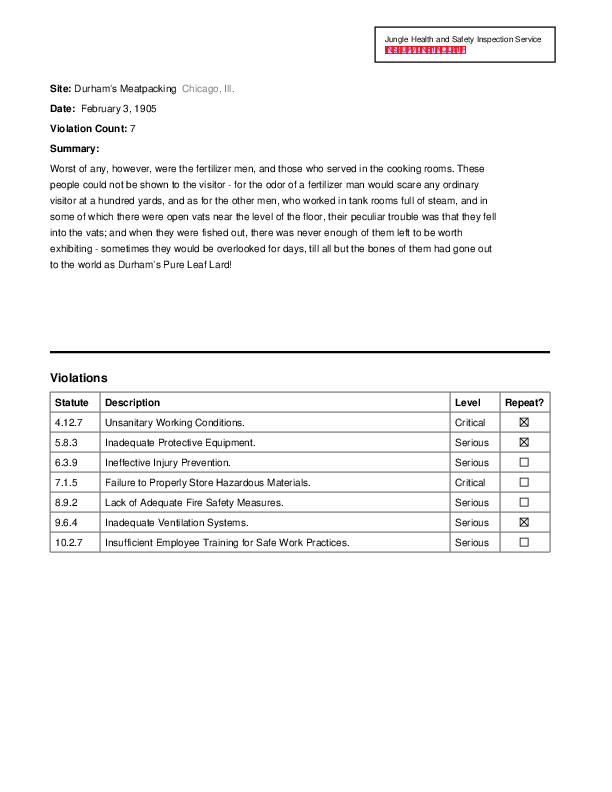

In [18]:
red_chars = [ c for c in page.chars if c["non_stroking_color"] == (1, 0, 0) ]
im.reset().draw_rects(red_chars)

Great! Now let's extract that, using a new method we haven't seen before: `.filter(...)`, which takes a function that will return `True` for objects we want to keep and `False` for those we want to ditch:

In [19]:
def is_red(obj):
    return obj.get("non_stroking_color") == (1, 0, 0)

print(page.filter(is_red).extract_text())

INS-UP70N51NCL41R


It worked!

Finally, let's try one more strategy and learn one more method: `.crop(...)`. Maybe we aren't sure the text will always be in red, nor that `Jungle Health and Safety Inspection Service` will always be the text that precedes it. What else can we use to home in on the inspection number?

How about the box surrounding it? From the debugging we did above, we know that the box is defined as a rectangle, and let's say we're pretty sure it'll always be the first one on the page. So let's do this:

1. Select the rectangle
2. Grab the rectangle's bounding box
2. Pass the bounding box to `page.crop(...)`
3. Extract the text

In [20]:
top_rect = page.rects[0]
top_rect_bbox = (top_rect["x0"], top_rect["top"], top_rect["x1"], top_rect["bottom"])
top_rect_bbox

(375, 27, 555, 62)

(We could also take advantage of one of `pdfplumber`'s utility functions to do the same:)

In [21]:
pdfplumber.utils.obj_to_bbox(top_rect)

(375, 27, 555, 62)

In [22]:
top_rect_cropped = page.crop(top_rect_bbox)

Let's check that the crop looks like what we intended:

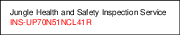

In [23]:
top_rect_cropped.to_image()

Great. Now, we can extract:

In [24]:
print(top_rect_cropped.extract_text())

Jungle Health and Safety Inspection Service
INS-UP70N51NCL41R


In [25]:
print(top_rect_cropped.extract_text().split("\n")[-1])

INS-UP70N51NCL41R


---

---

---